# Sample Siemens Analysis

# Select Image & Phantom and Parse

In [1]:
from pyquantus.parse.siemens import siemensParser

In [2]:
imagePath = "/Volumes/CREST Data/David_S_Data/Thyroid_Analyzable/TRF01/uri_SpV1712_VpF512_FpA78_20190830131431.rfd"
phantomPath = "/Volumes/CREST Data/David_S_Data/Thyroid_Analyzable/Phantom/uri_SpV2232_VpF512_FpA90_20210129103529.rfd"

In [3]:
bmode, imgData, imgInfo, refData, refInfo = siemensParser(imagePath, phantomPath)

# ROI Selection (from GUI)

In [4]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/Thyroid_Analyzable/Phantom/roi.pkl"

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_94129/3922677974.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  roi_info = pickle.load(f)


In [5]:
from pathlib import Path

assert roi_info["Image Name"] == Path(imagePath).name
assert roi_info["Phantom Name"] == Path(phantomPath).name

In [6]:
splineX = roi_info["Spline X"]
splineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [7]:
from pyquantus.qus import AnalysisConfig

config = AnalysisConfig()

config.transducerFreqBand = [2000000, 13000000] # [min, max] (Hz)
config.analysisFreqBand = [4500000, 9500000] # [lower, upper] (Hz)
config.samplingFrequency = 40000000 # Hz
config.axWinSize = 0.54 # axial length per window (mm)
config.latWinSize = 0.54 # lateral length per window (mm)
config.windowThresh = 0.95 # % of window area required to be considered in ROI
config.axialOverlap = 0.5 # % of window overlap in axial direction
config.lateralOverlap = 0.5 # % of window overlap in lateral direction
config.centerFrequency = 10000000 # Hz

# Spectral Analysis

In [8]:
from pyquantus.qus import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]

In [9]:
from pyquantus.qus import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.splineX = splineX
spectralAnalysis.splineY = splineY

In [10]:
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

# Visualizations

In [11]:
from pyquantus.qus import SpectralData

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis

In [12]:
spectralData.convertImagesToRGB()

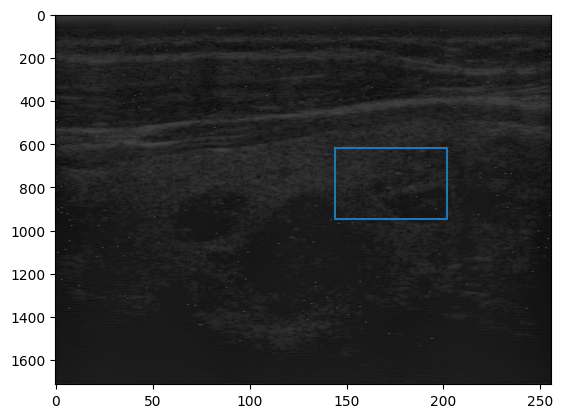

In [13]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.bmode, aspect='auto')
plt.plot(splineX, splineY)

In [14]:
spectralData.drawCmaps()

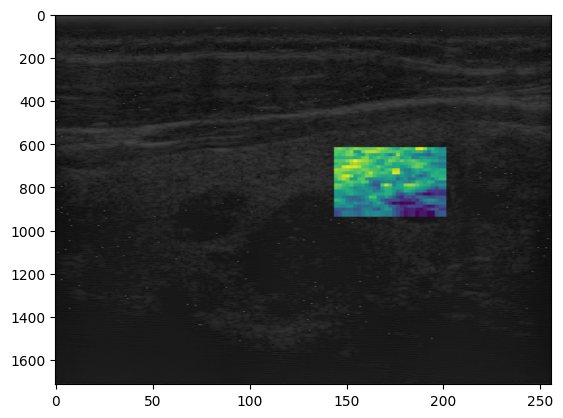

In [15]:
plt.imshow(spectralData.mbfIm, aspect='auto')

In [16]:
import numpy as np
np.mean(spectralData.mbfArr), np.mean(spectralData.siArr), np.mean(spectralData.ssArr)

(np.float64(25.884521297341053),
 np.float64(55.98795057394216),
 np.float64(-4.301765338531746e-06))